# Tutorial 16: Randomized DMD

In this tutorial, we re-examine the system explored in [Tutorial 4](https://pydmd.github.io/PyDMD/tutorial4cdmd.html) and compare the performance of compressed DMD (CDMD) and randomized DMD (RDMD) [1] as a means of improving the efficiency of the exact DMD algorithm. We highlight RDMD as an effective alternative to its predecessor CDMD, while also highlighting how one might tune the parameters of RDMD in order to balance accuracy and efficiency.

[1] N. B. Erichson, L. Mathelin, J. N. Kutz, and S. L. Brunton, *Randomized dynamic mode decomposition*, SIAM J. Appl. Dyn. Syst., 18 (2019), pp. 1867-1891.

We begin by importing the `RDMD` class from the PyDMD package, along with the `DMD` and `CDMD` classes for performance comparisons. We also import the `time` module for calculating runtimes, `numpy` for mathematical computations, and `matplotlib.pyplot` for plotting.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from pydmd import DMD, CDMD, RDMD

We then define a function for calculating relative error, along with a function for computing the CDMD compression matrix used in [Tutorial 4](https://pydmd.github.io/PyDMD/tutorial4cdmd.html).

In [2]:
def compute_error(true, est):
    """
    Computes and returns relative error.
    """
    return np.linalg.norm(true - est) / np.linalg.norm(true)

def build_compression_matrix(snapshots_matrix):
    """
    Computes and returns the CDMD compression matrix used in Tutorial 4.
    """
    random_matrix = np.random.permutation(
        snapshots_matrix.shape[0] * snapshots_matrix.shape[1]
    )
    random_matrix = random_matrix.reshape(
        snapshots_matrix.shape[1], snapshots_matrix.shape[0]
    )
    compression_matrix = random_matrix / np.linalg.norm(random_matrix)

    return compression_matrix

Now, we re-create the helper function from [Tutorial 4](https://pydmd.github.io/PyDMD/tutorial4cdmd.html) that returns data snapshots for a given spatial and temporal resolution. Each data snapshot is the sum of the following three components, with $x \in [-5, 5]$ and $t \in [0, 4\pi]$.

- $f_1(x, t) = e^{-\frac{x^2}{5}}\,\cos(4x)\,e^{(2.3i)t}$
- $f_2(x, t) = \bigg(1-e^{1-\frac{x^2}{6}}\bigg)e^{(1.3i)t}$
- $f_3(x, t) = \bigg(-\frac{x^2}{50} + 1\bigg)1.1i^{-2t}$

Here we produce our toy data for 256 spatial collocation points across 128 time points. We then add Gaussian noise

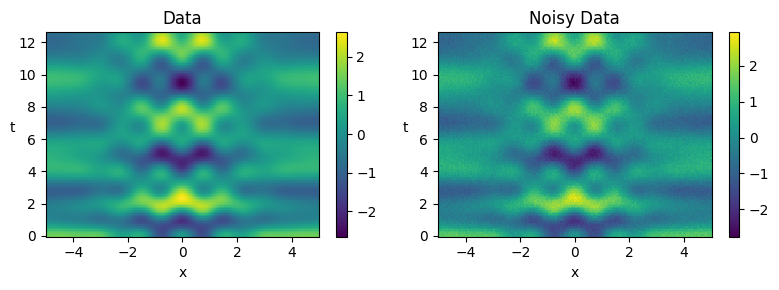

In [48]:
def create_dataset(x_dim, t_dim):
    """
    Args:
    x_dim = resolution along the x range [-5, 5]
    t_dim = resolution along the t range [0, 4*pi]

    Returns:
    x_grid = x collocation points
    t_grid = t collocation points
    X = (t_dim, x_dim) np.ndarray of snapshot data
    """
    # Define the x and t collocation points.
    x = np.linspace(-5, 5, x_dim)
    t = np.linspace(0, 4 * np.pi, t_dim)
    xgrid, tgrid = np.meshgrid(x, t)

    # Define the modes that make up each snapshot.
    def f1(x, t):
        return np.exp(-(x**2) * 0.2) * np.cos(4 * x) * np.exp(2.3j * t)

    def f2(x, t):
        return (1 - np.exp(1 - x**2 / 6)) * np.exp(1.3j * t)

    def f3(x, t):
        return (-0.02 * x**2 + 1) * (1.1j ** (-2 * t))

    # Evaluate modes at each collocation point.
    X1 = f1(xgrid, tgrid)
    X2 = f2(xgrid, tgrid)
    X3 = f3(xgrid, tgrid)

    return xgrid, tgrid, (X1 + X2 + X3)

# Generate and visualize the toy dataset.
xgrid, tgrid, X = create_dataset(x_dim=256, t_dim=128)

# Generate noisy data for a given noise magnitude. Seed is used for reproducibility.
noise_mag = 0.1
rng = np.random.default_rng(seed=42)
X_noisy = X + (noise_mag * rng.standard_normal(X.shape))

# Plot both the clean and the noisy data sets. 
plt.figure(figsize=(8, 3))
for i, (mat, name) in enumerate(zip([X, X_noisy], ["Data", "Noisy Data"])):
    plt.subplot(1, 2, i + 1)
    plt.pcolor(xgrid, tgrid, mat.real)
    plt.colorbar()
    plt.title(name)
    plt.xlabel("x")
    plt.ylabel("t", rotation=0)
plt.tight_layout()
plt.show()

In [49]:
snapshots_matrix = X.T
snapshots_matrix_noisy = X_noisy.T

t0 = time.time()
dmd = DMD(svd_rank=3, exact=True)
dmd.fit(snapshots_matrix_noisy)
t1 = time.time()
dmd_error = compute_error(snapshots_matrix, dmd.reconstructed_data)
dmd_time = t1 - t0

print(f"DMD Reconstruction Error: {dmd_error}")
print(f"DMD Runtime: {dmd_time}")

DMD Reconstruction Error: 0.017055067185650967
DMD Runtime: 0.241591215133667


In [63]:
num_trials = 50
cdmd_error = 0.0
cdmd_time = 0.0

for j in range(num_trials):
    t0 = time.time()
    cdmd = CDMD(svd_rank=3).fit(snapshots_matrix_noisy)
    t1 = time.time()
    cdmd_error += compute_error(snapshots_matrix, cdmd.reconstructed_data) / num_trials
    cdmd_time += (t1 - t0) / num_trials

print(f"CDMD Reconstruction Error: {cdmd_error}")
print(f"CDMD (Average) Runtime: {cdmd_time}")

CDMD Reconstruction Error: 0.02887105530592139
CDMD (Average) Runtime: 0.13727683544158933


In [51]:
oversampling_default = 10
oversampling_values = np.arange(0, 101, 10)
oversampling_error = np.zeros(len(oversampling_values))
oversampling_times = np.zeros(len(oversampling_values))

for i, k in enumerate(oversampling_values):
    for j in range(num_trials):
        t0 = time.time()
        rdmd = RDMD(svd_rank=3, oversampling=k).fit(snapshots_matrix_noisy)
        t1 = time.time()
        oversampling_error[i] += compute_error(snapshots_matrix, rdmd.reconstructed_data) / num_trials
        oversampling_times[i] += (t1 - t0) / num_trials

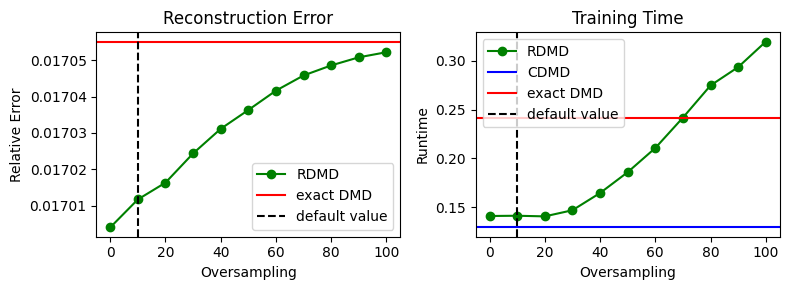

In [59]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(oversampling_values, oversampling_error, "-o", c="g", label="RDMD")
# plt.axhline(y=cdmd_error, c="b", label="CDMD")
plt.axhline(y=dmd_error, c="r", label="exact DMD")
plt.axvline(x=oversampling_default, ls="--", c="k", label="default value")
plt.title("Reconstruction Error")
plt.xlabel("Oversampling")
plt.ylabel("Relative Error")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(oversampling_values, oversampling_times, "-o", c="g", label="RDMD")
plt.axhline(y=cdmd_time, c="b", label="CDMD")
plt.axhline(y=dmd_time, c="r", label="exact DMD")
plt.axvline(x=oversampling_default, ls="--", c="k", label="default value")
plt.title("Training Time")
plt.xlabel("Oversampling")
plt.ylabel("Runtime")
plt.legend()
plt.tight_layout()
plt.show()

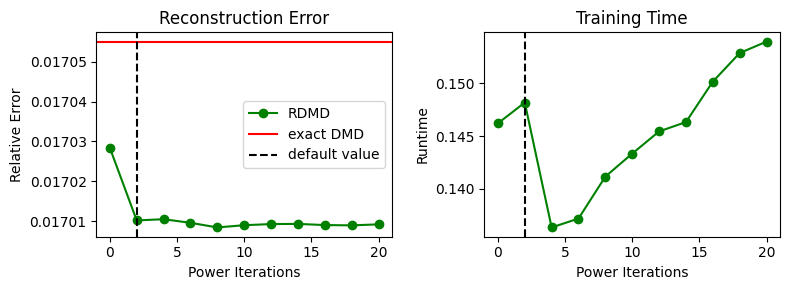

In [62]:
power_iter_default = 2
power_iter_values = np.arange(0, 21, 2)
power_iter_error = np.zeros(len(power_iter_values))
power_iter_times = np.zeros(len(power_iter_values))

for i, k in enumerate(power_iter_values):
    for j in range(num_trials):
        t0 = time.time()
        rdmd = RDMD(svd_rank=3, power_iters=k).fit(snapshots_matrix_noisy)
        t1 = time.time()
        power_iter_error[i] += compute_error(snapshots_matrix, rdmd.reconstructed_data) / num_trials
        power_iter_times[i] += (t1 - t0) / num_trials

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(power_iter_values, power_iter_error, "-o", c="g", label="RDMD")
# plt.axhline(y=cdmd_error, c="b", label="CDMD")
plt.axhline(y=dmd_error, c="r", label="exact DMD")
plt.axvline(x=power_iter_default, ls="--", c="k", label="default value")
plt.title("Reconstruction Error")
plt.xlabel("Power Iterations")
plt.ylabel("Relative Error")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(power_iter_values, power_iter_times, "-o", c="g", label="RDMD")
# plt.axhline(y=cdmd_time, c="b", label="CDMD")
# plt.axhline(y=dmd_time, c="r", label="exact DMD")
plt.axvline(x=power_iter_default, ls="--", c="k", label="default value")
plt.title("Training Time")
plt.xlabel("Power Iterations")
plt.ylabel("Runtime")
plt.tight_layout()
plt.show()

C:\Users\sarai\AppData\Local\Programs\Python\Python310\lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 1.0904897672548342e+17. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


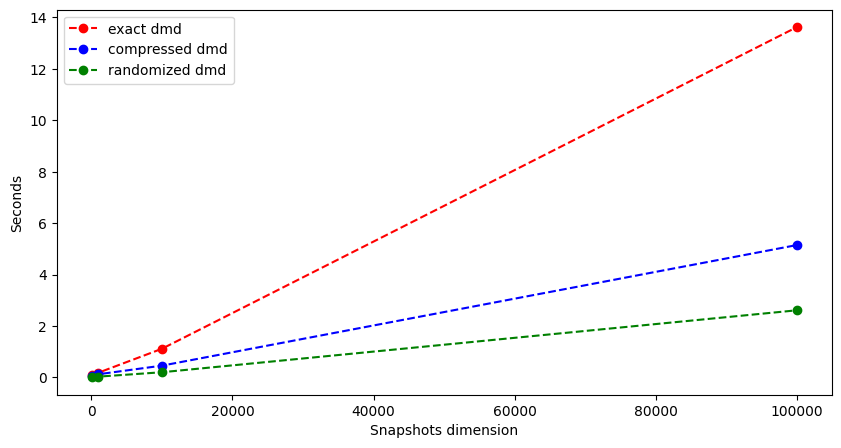

In [75]:
time_dmd = []
time_cdmd = []
time_rdmd = []

niter = 4
nsnap = 100
ndims = 10 ** np.arange(2, 2 + niter)
for ndim in ndims:
    snapshots_matrix = create_dataset(ndim, nsnap)[-1].T

    # Build compression matrix for CDMD.
    compression_matrix = build_compression_matrix(snapshots_matrix)
    
    # Build random matrix for RDMD.
    rand_mat = np.random.randn(snapshots_matrix.shape[-1], 5)

    t0 = time.time()
    DMD(svd_rank=-1, exact=True).fit(snapshots_matrix)
    t1 = time.time()
    time_dmd.append(t1 - t0)

    t0 = time.time()
    CDMD(svd_rank=-1, compression_matrix=compression_matrix).fit(snapshots_matrix)
    t1 = time.time()
    time_cdmd.append(t1 - t0)
    
    t0 = time.time()
    RDMD(svd_rank=-1, rand_mat=rand_mat).fit(snapshots_matrix)
    t1 = time.time()
    time_rdmd.append(t1 - t0)

plt.figure(figsize=(10, 5))
plt.plot(ndims, time_dmd, "ro--", label="exact dmd")
plt.plot(ndims, time_cdmd, "bo--", label="compressed dmd")
plt.plot(ndims, time_rdmd, "go--", label="randomized dmd")
plt.legend()
plt.ylabel("Seconds")
plt.xlabel("Snapshots dimension")
plt.show()